In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import numpy as np
from scipy.stats import ttest_rel, f_oneway
import statsmodels.stats.multicomp as mc

# === CONFIGURATION ===
input_dir = "/root/autodl-tmp/Prime/brain_cancer/Results"  # 修改为你的路径
output_dir = "/root/autodl-tmp/Prime/brain_cancer/Results/comparison/visualization_results-new"
os.makedirs(output_dir, exist_ok=True)

# === LOAD CSV FILES ===
csv_files = [f for f in os.listdir(input_dir) if f.endswith('.csv')]
dataframes = {
    os.path.splitext(f)[0]: pd.read_csv(os.path.join(input_dir, f), index_col=0)
    for f in csv_files
}
model_names = list(dataframes.keys())
metrics = dataframes[model_names[0]].columns[:-1]  # 最后一列为True_expression

# === COLOR CUTOFF ===
true_expr = list(dataframes.values())[0]['True_expression']
vmin, vmax = np.percentile(true_expr, [5, 95])

# === SCATTER PLOTS ===
# 越大越好的指标
larger_better_metrics = {'SSIM', 'PSNR', 'PCC', 'Spearman', 'MI', 'AUC', 'R2'}
smaller_better_metrics = {'RMSE', 'MSE', 'JS_Div'}

import math

import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import numpy as np

for metric in metrics:
    combinations = list(itertools.combinations(model_names, 2))
    n_plots = len(combinations)
    ncols = min(6, n_plots)
    nrows = math.ceil(n_plots / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))

    if n_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for idx, (model1, model2) in enumerate(combinations):
        ax = axes[idx]

        df1 = dataframes[model1]
        df2 = dataframes[model2]
        genes = df1.index.intersection(df2.index)

        x = df1.loc[genes, metric]
        y = df2.loc[genes, metric]
        expr = df1.loc[genes, 'True_expression']
        expr = (expr - expr.min()) / (expr.max() - expr.min())

        # 自动色阶 cutoff
        vmin = np.percentile(expr, 20)
        vmax = np.percentile(expr, 80)

        scatter = ax.scatter(x, y, c=expr, cmap='viridis', s=10, vmin=vmin, vmax=vmax)

        min_val = min(x.min(), y.min())
        max_val = max(x.max(), y.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1)

        if metric in larger_better_metrics:
            improvement = (y > x).sum()
        elif metric in smaller_better_metrics:
            improvement = (y < x).sum()
        else:
            improvement = (y > x).sum()

        prop = improvement / len(x)
        ax.set_title(f"{model1} vs {model2}\nImproved: {prop:.2f} ({improvement})")
        ax.set_xlabel(model1)
        ax.set_ylabel(model2)

        # 添加 colorbar
        cbar = fig.colorbar(scatter, ax=ax)
        cbar.set_label('True Expression')

    for k in range(len(combinations), len(axes)):
        fig.delaxes(axes[k])

    plt.suptitle(f"Scatter Comparison for '{metric}'", fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig(os.path.join(output_dir, f"scatter_{metric}_allinone.png"), dpi=300, bbox_inches='tight')
    plt.close()

/tmp/ipykernel_15825/2171493726.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=melted, x="Model", y=metric, palette="Set2")
/tmp/ipykernel_15825/2171493726.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=melted, x="Model", y=metric, palette="Set2")
/tmp/ipykernel_15825/2171493726.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=melted, x="Model", y=metric, palette="Set2")
/tmp/ipykernel_15825/2171493726.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed

UnboundLocalError: cannot access local variable 'boxprops' where it is not associated with a value

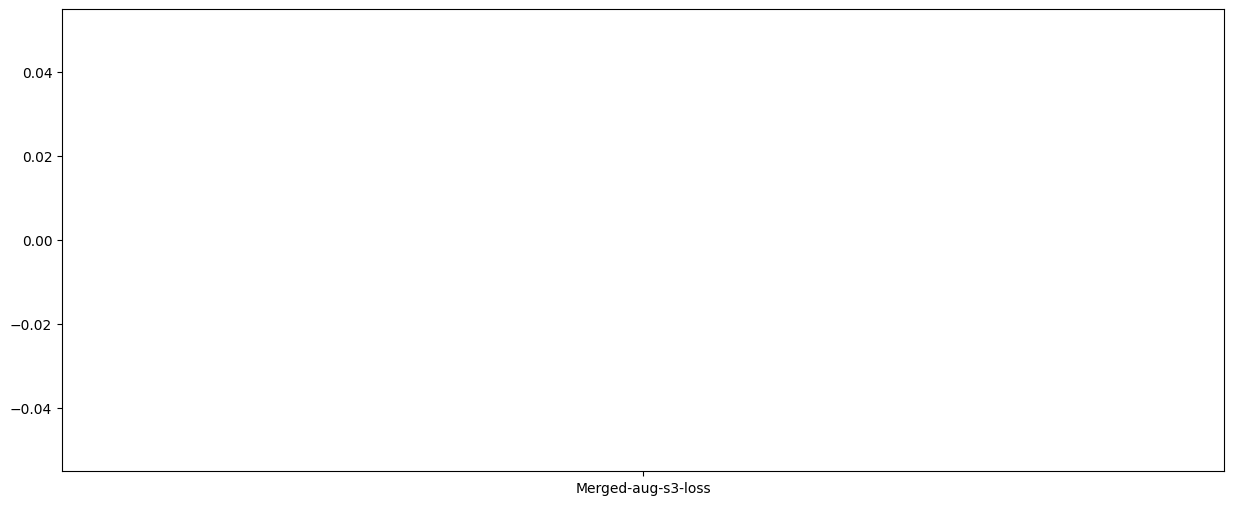

In [15]:
# === BOX PLOTS WITH STATS ===
for metric in metrics:
    metric_df = pd.DataFrame({name: df[metric] for name, df in dataframes.items()})
    melted = metric_df.melt(var_name="Model", value_name=metric)

    plt.figure(figsize=(15, 6))
    ax = sns.boxplot(data=melted, x="Model", y=metric, palette="Set2")
    sns.stripplot(data=melted, x="Model", y=metric, color='black', alpha=0.3, size=2, jitter=0.2)

    model_vals = [dataframes[name][metric] for name in model_names]
    ymax = melted[metric].max()
    ymin = melted[metric].min()
    y_range = ymax - ymin

    plt.title(f"Boxplot of {metric}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # 给标题留点空间
    plt.savefig(os.path.join(output_dir, f"boxplot_{metric}.png"), dpi=300)
    plt.close()